# Find Dishonest Restaurant
<img src="https://www.netclipart.com/pp/m/349-3494556_forex-scams-by-dishonest-person-lying-cartoon.png" width="600px">

## Description

Sometimes, some dishonest restaurants cheating TripAdvisor and their guests by winding up the rating higher than it should be.

The main aim of the project is to try to predict the rating of the restaurant with given data.

In case if the predictions of our model have significant differences from the actual result, then, most likely we found a dishonest restaurant. 

### Column Defination

Restaurant_id — restaurant / restaurant chain identification number;

City — In what city it is located;

Cuisine Style — related to a restaurant cuisine;

Ranking — the place that this restaurant occupies among all restaurants in its city;

Rating — restaurant rating according to TripAdvisor (Target Variable);

Price Range — restaurant price range;

Number of Reviews — Number of Reviews ;

Reviews — data about two reviews that are displayed on the restaurant's website;

URL_TA — URL on TripAdvisor;

ID_TA — Identificator of restaurant in TripAdvisor's DataBase.


---
### Import Libraries
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from datetime import timedelta
from textblob import TextBlob # for sentiment analysis
from wordcloud import WordCloud # for sentiment analysis

warnings.filterwarnings('ignore')

#from jupyterthemes import jtplot

pd.set_option('display.max_rows', 50)  # Show more rows
pd.set_option('display.max_columns', 50)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

%matplotlib inline

#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

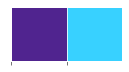

In [2]:
 #colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff']
colors = ['#50248f','#38d1ff']
sns.palplot(sns.color_palette(colors))

### 1.  Read and Chek the Dataset

In [3]:
df = pd.read_csv('main_task.csv')
print(f'Dataset shape: {df.shape}')

Dataset shape: (40000, 10)


### 1.1 Show basic info

In [4]:
display(df.head())
df.info()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


### 1.2 Show the data types

In [5]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').agg('count').reset_index()

,Column Type,Count
0,float64,3
1,object,7


Let's see what type of data in each column-cell

In [6]:
for i,j in enumerate(df.columns):
    print(j,type(df.loc[1][i]))

Restaurant_id <class 'str'>
City <class 'str'>
Cuisine Style <class 'float'>
Ranking <class 'numpy.float64'>
Rating <class 'numpy.float64'>
Price Range <class 'float'>
Number of Reviews <class 'numpy.float64'>
Reviews <class 'str'>
URL_TA <class 'str'>
ID_TA <class 'str'>


Well, it is more interesting. Let's briefly see at the content of object data.

In [7]:
obj = df.dtypes[df.dtypes == 'object'].index
print(obj)

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews',
       'URL_TA', 'ID_TA'],
      dtype='object')


In [8]:
for i in obj:
    print(f'Col Name: {i}, Content: {df[i].unique()}\n')

Col Name: Restaurant_id, Content: ['id_5569' 'id_1535' 'id_352' ... 'id_7068' 'id_8887' 'id_6057']

Col Name: City, Content: ['Paris' 'Stockholm' 'London' 'Berlin' 'Munich' 'Oporto' 'Milan'
 'Bratislava' 'Vienna' 'Rome' 'Barcelona' 'Madrid' 'Dublin' 'Brussels'
 'Zurich' 'Warsaw' 'Budapest' 'Copenhagen' 'Amsterdam' 'Lyon' 'Hamburg'
 'Lisbon' 'Prague' 'Oslo' 'Helsinki' 'Edinburgh' 'Geneva' 'Ljubljana'
 'Athens' 'Luxembourg' 'Krakow']

Col Name: Cuisine Style, Content: ["['European', 'French', 'International']" nan
 "['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']"
 ...
 "['Steakhouse', 'Barbecue', 'Australian', 'Argentinean', 'South American']"
 "['French', 'American', 'Cafe', 'Healthy', 'Soups']"
 "['French', 'Contemporary', 'Fusion', 'Gastropub']"]

Col Name: Price Range, Content: ['$$ - $$$' nan '$$$$' '$']

Col Name: Reviews, Content: ["[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"
 "[

Well, that is clearly obvious,that some data in columns pretend to be as a list, however it is string or float type.

Such as:
 - column Cuisine Style is looks like a list, but has float64 type;
 - column Reviews looks like nested list with following template [[ comment_1 , comment_2 ], [date1 , date2]], but in fact it has str type of data.

Rename columns removing spaces and substituting capital letters

In [9]:
df.rename(columns={'Restaurant_id': 'restaurant_id',
                   'City' : 'city',
                   'Cuisine Style': 'cuisine_style',
                   'Ranking': 'ranking',
                   'Rating': 'rating',
                   'Price Range' :'price_range',
                   'Number of Reviews': 'reviews_number',
                   'Reviews': 'reviews',
                   'URL_TA': 'url_ta',
                   'ID_TA' : 'id_ta'},inplace=True)
# show the data
df.head(1)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


### 1.3 Missing values

restaurant_id - 0%
city - 0%
cuisine_style - 23%
ranking - 0%
rating - 0%
price_range - 35%
reviews_number - 6%
reviews - 0%
url_ta - 0%
id_ta - 0%


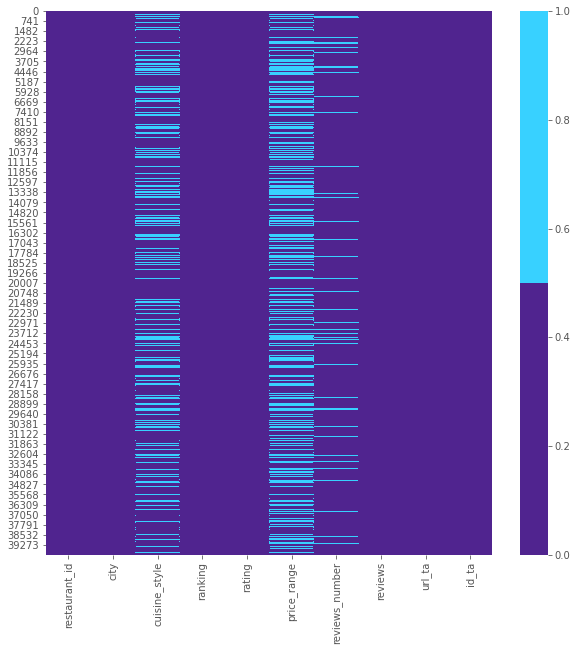

In [10]:
# Plot missing values
cols = df.columns
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df[cols].isnull(),cmap=sns.color_palette(colors))

# Show in percents

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

---
## Resume
---

 - DataSet has 40k rows and 10 columns.
 - Column 'cuisine_style' has 23% of missing values
 - Column 'price_range' has 35% of missing values
 - Column 'reviews_number' has 6% of missing values while column 'reviews' has no any single missing value. Here is a discrepancy. If we visually check the content of the column 'reviews', we find the following value :'[[],[]]'. Definatelly it is a missing value which need to be treated in further data-preprocessing.
 - Type in particular cell sometimes differ with pd.dtypes. Need to take care about that in further.


## 2. Exploratory Data Analysis

### 2.1 Target Variable analysis

Text(0.5, 0, 'Rating')

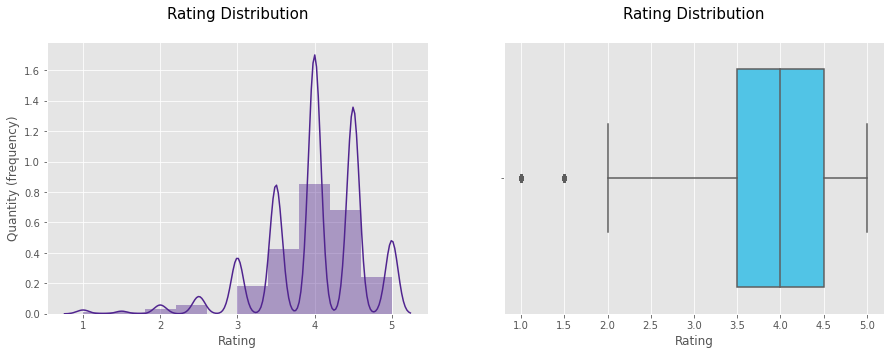

In [11]:
plt.figure(figsize=(15 ,5))
plt.subplot(121)
sns.distplot(df.rating.values, bins=10,color=colors[0])
plt.title('Rating Distribution\n', fontsize=15)
plt.xlabel ('Rating')
plt.ylabel ('Quantity (frequency)')

plt.subplot(122)
sns.boxplot(df.rating.values, color=colors[1])
plt.title('Rating Distribution\n', fontsize=15)
plt.xlabel('Rating')

In [12]:
df['rating'].describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

The Target variable has a normal distribution shifted to the right side of 1 to 5. The first and third quartiles are in the range from  3.5 to 4.5, the median is 4. Also outliers has been observed for target variable.

### 2.2 Restaurant_Id column

In [13]:
print(f'Unique Id quantity: {df.restaurant_id.nunique()}')
df['restaurant_id'].value_counts()

Unique Id quantity: 11909


id_436      18
id_227      18
id_871      18
id_633      18
id_71       17
            ..
id_5080      1
id_10427     1
id_10344     1
id_13155     1
id_9815      1
Name: restaurant_id, Length: 11909, dtype: int64

---

Well, the total quantity of rows is 40k while number of unique id is 11k.

We may see some dublicates here. But:

With a reference to a column description it may says us that we have some chain restaurants in dataset.

---

### 2.3 City column

How are cities distrubuted?

Total Number of Cities in DataSet: 31


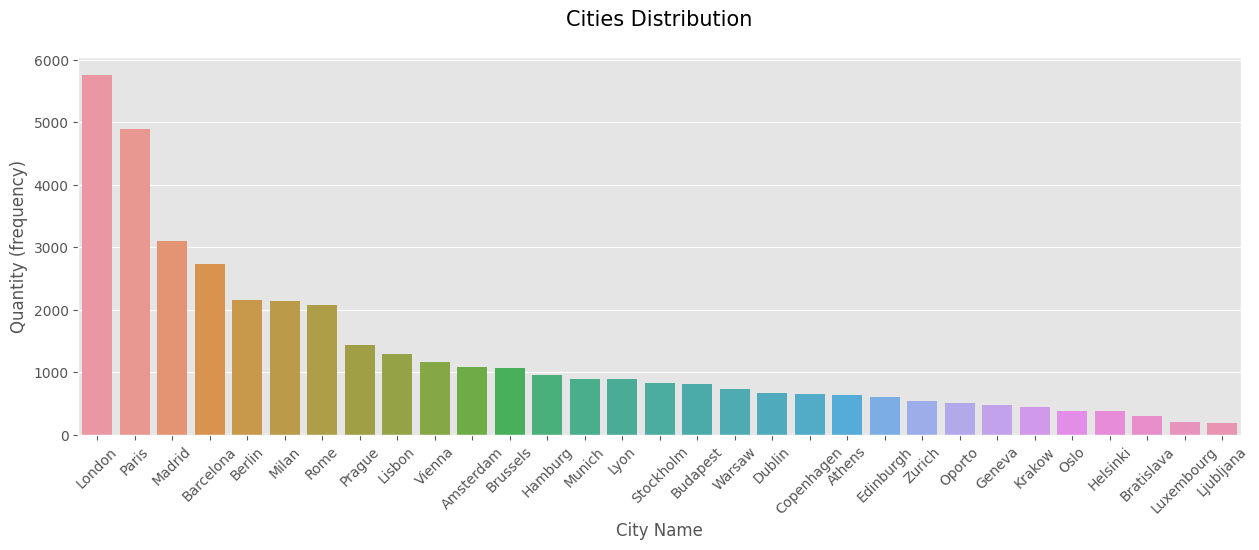

In [14]:
plt.figure(figsize=(15 ,5),dpi = 100)
sns.countplot(df['city'], order=df['city'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Cities Distribution\n', fontsize=15)
plt.xlabel ('City Name')
plt.ylabel ('Quantity (frequency)')

print(f'Total Number of Cities in DataSet: {df.city.nunique()}')

---

The overwhelming majority of restaurants presented in the dataset located in London, Paris, Madrid. 

All cities are European.

The city of Oporto is not identified. It is actually the name of the restaurant in Porto(Portugal)

Most likely it shall be Porto instead of Oporto.

---

### 2.4 Cuisine_style column

First of all, we have to manage the list of cuisines in a way that we can use the data and produce some statistics.

In [15]:
# Before we start, we need to save an information in dataset, where there were a missing values

# Create a column where indicate that Cuisine is not presented for this restaurant
df['cuisine_ctyle_empty'] = df['cuisine_style'].isnull().astype('uint8')

# Fill missed values in column with 'unknown'
df['cuisine_style'] = df['cuisine_style'].fillna("['unknown']")

# convert string in the column into a list
df['cuisine_style'] = df['cuisine_style'].apply(lambda x: eval(x))

# Create separate dataframe for analyse

df1 = df[['city','cuisine_style','ranking','rating','reviews_number']].explode('cuisine_style')

print(df1['cuisine_style'].nunique()-1) # -1 cos we already filled missed value. Dont count it

125


Check  a top 10 of the most common cuisine styles

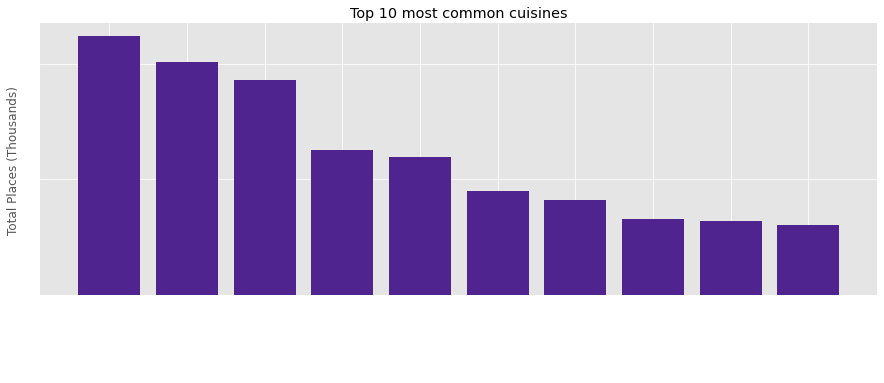

In [16]:
df_cuisine_style = df1.cuisine_style.value_counts().sort_values(ascending = False)[:10]

count_ths = np.arange(0, 1.3e4, 5e3)
count = np.arange(0, 20, 5)


fig = plt.figure(figsize=(15, 5))
ax = plt.subplot();


plt.bar(x = df_cuisine_style.index, height=df_cuisine_style, color=colors[0]);

plt.yticks(count_ths, count);
plt.xticks(rotation=45)
plt.ylabel('Total Places (Thousands)');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Top 10 most common cuisines');
ax.tick_params(direction='out', length=0, width=0, colors='white');

--- 
The dataset has 125 unique cuisines.

Vegetarian Friendly places are clearly the most common ones around Europe, followed by mostly European-style cuisine.

---

Which are the cuisines that people tend to review?

In [17]:
df_cuisine_style = df1.groupby('cuisine_style').reviews_number.sum().sort_values(ascending=False)[:10]

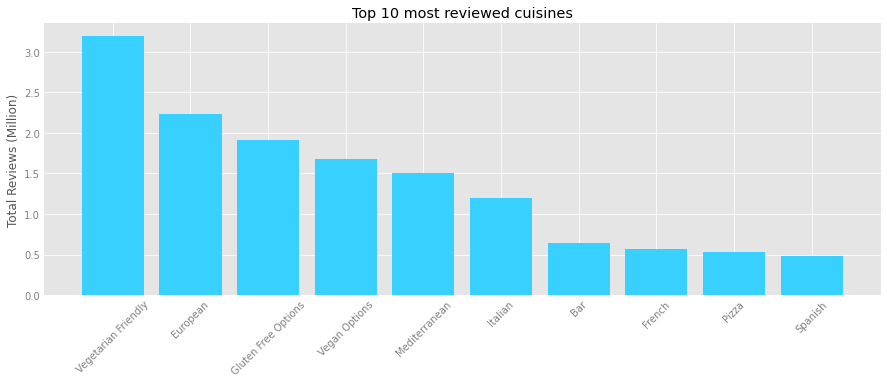

In [18]:
count_ths = np.arange(0, 3.3e6, 5e5)
count = np.arange(0, 9.3, 0.5)

fig = plt.figure(figsize=(15, 5))
ax = plt.subplot();

plt.bar(x = df_cuisine_style.index, height=df_cuisine_style, color=colors[1]);

plt.yticks(count_ths, count);
plt.xticks(rotation=45)
plt.ylabel('Total Reviews (Million)');
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
plt.title('Top 10 most reviewed cuisines');
ax.tick_params(direction='out', length=0, width=0, colors='grey');

---

The chart is more or less simillar with above one.But it's notable that the Vegan and Gluten Free Options are very likely to be reviewed by the customers.

People are not tend to review restaurants where cuisins are not shown. So we made a right desicion to keep (but not delete) rows with missing cuisins by replacing nan value to 'unknown'. Perhaps this info may help us in further modeling.

---

### 2.5 Ranking column

How is it distributed?

Text(0.5, 0, 'Ranking')

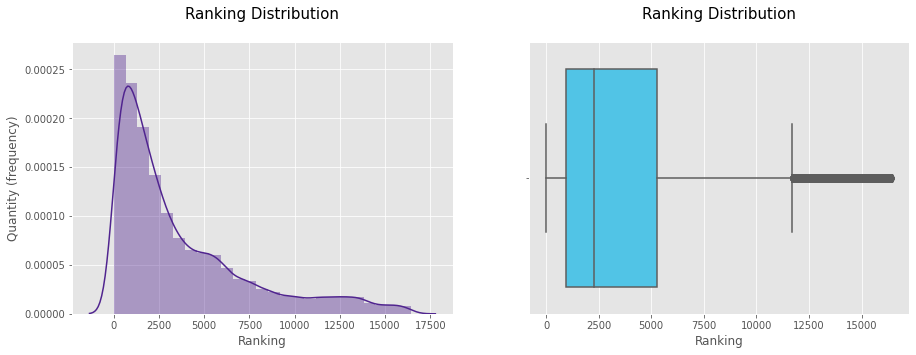

In [19]:
plt.figure(figsize=(15 ,5))
plt.subplot(121)
sns.distplot(df.ranking.values, bins=25,color=colors[0])
plt.title('Ranking Distribution\n', fontsize=15)
plt.xlabel ('Ranking')
plt.ylabel ('Quantity (frequency)')

plt.subplot(122)
sns.boxplot(df.ranking.values, color=colors[1])
plt.title('Ranking Distribution\n', fontsize=15)
plt.xlabel('Ranking')

In [20]:
df['ranking'].describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

---

The Ranking distribution shifted to the left side and scattered from 1 to 16444. The first and third quartiles are in the range from 973 to 5260, the median is 2285.

However, with a reference to the data description, the Ranking is the place that this restaurant occupies among all restaurants in its city. So we cannot observe it separately from cities.

---

So, let's plot a distribution of a ranking depend on city (take 10-top cities in dataset)

Text(0, 0.5, 'Quantity (frequency)')

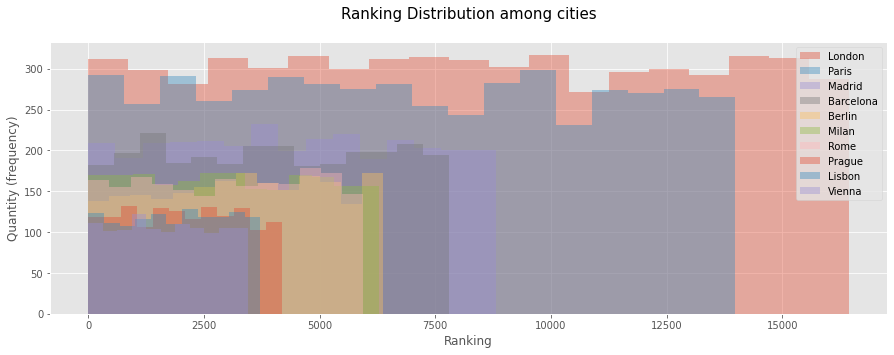

In [21]:
plt.figure(figsize=(15 ,5))

for city in (df['city'].value_counts())[0:10].index:  
    sns.distplot(df['ranking'][df['city'] == city],kde=False,label = city)
    
plt.legend(prop={'size': 10})
plt.title('Ranking Distribution among cities\n', fontsize=15)
plt.xlabel('Ranking')
plt.ylabel('Quantity (frequency)')

---

Well, as we see the ranking has normal distribution in each separate city. And as we already know , London is taking a top place by presented restaurants. So it in not surprised, that why do we have a shifting of distribution in a left side. Big cities has lots of restaurants.

Then in a further future engeniring section (below) we need to consider this by creating equivalent ranking.

---

Chek the correlation

Rank of Matrix: 4
Determinat of matrix :0.778
Shape of matrix :(4, 4)


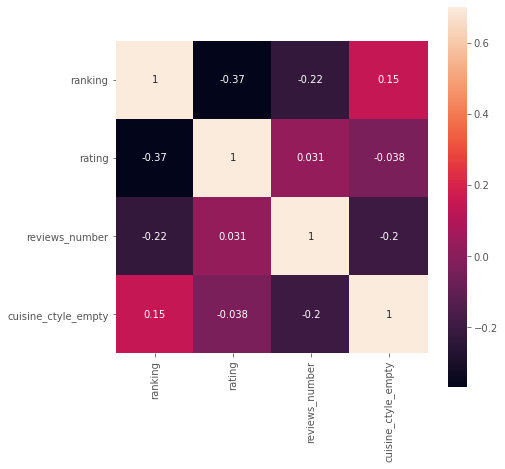

In [22]:
X = df.corr()
fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(X, vmax=.7, square=True, annot=True)

print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
print(f'Determinat of matrix :{np.round(np.linalg.det(X),3)}')
print(f'Shape of matrix :{np.shape(X)}')

---

Here we can see some correlations with target variable.

There is no correlations between features. It is also confirmed by rank of correlation matrix. It has full rank.

Most likely, we won't have a problems in a modeling

----

### 2.6 Price range column

First of all, with a reference to a section 1, we know that this column has 35% of nan values and presented as dollar symbol

Let's replace these symbols in the dataset for the three price ranges with  more intuitive (cheap - medium - high ranges) and replace the NaN ones (set as not available)

In [23]:
df['price_range'] = df['price_range'].fillna('NA')
price_ranges = {'$': 'Cheap', '$$ - $$$': 'Medium',
                '$$$$': 'High', 'NA': 'NotAvailable'}
df['price_range'] = df['price_range'].map(price_ranges)

Text(0, 0.5, 'Rating')

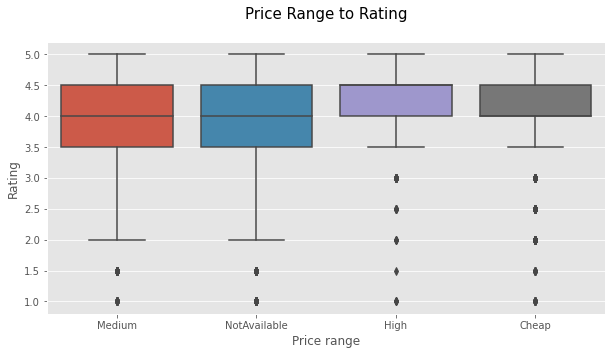

In [24]:
plt.figure(figsize=(10 ,5))

sns.boxplot(x='price_range',y= 'rating',data=df)

plt.title('Price Range to Rating\n', fontsize=15)
plt.xlabel ('Price range')
plt.ylabel ('Rating')

---

Well, restaurants with high prices and cheap prices getting low ratings less often than restaurants with a medium level

---

### 2.7 Reviews number column

---

We already know that this column has nan values. Also we know that The most reviewable cuisin is vegan

Missing values will be filled in Feature engineering section.

Important Note. 

Filling the missing data must be done in a complex with proceeding the reviews column as we note that there is some descripancy between review numbers and revies itself

---

### 2.8 Reviews column

#### 2.8.1 Pre-processing and analyse of missing values

Let's re-call what have we seen in section 1 of this notebook

In [25]:
print(df['reviews'][0])
print(df['reviews'][3])
print(f'Govno {type(df.loc[1]["reviews"])}')

[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]
[[], []]
Govno <class 'str'>


Well, as was mentioned above the content has structural data - [ [ ],[ ] ].

**However** it is not a list, but just a string type.

Then, we want to extract the data form the colums 'reviews' into a 4 independent colums and remove original one from dataset.

In the end we shall get following columns in our dataset:

***Review_1*** - we put review No.1 (if any).

***Date_1*** - we put the date when the review was added

***Review_2*** - we put review No.2 (if any).

***Date_2*** - we put the date when the review was added

***Diff_rev*** - Time difference in days between first and second review


In [26]:
# create a template for search
lrx = re.compile('\[\[.*\]\]')


def review_extraction(row):
    
    '''Function is called for extracting data from column 
    reviews and splitting it out into a separate columns
    INPUT: Whole dataset
    OUTPUT: Dataset with additional columns'''
    
    cell = row['reviews']
    aux_list = [[], []] # create an auxilliary list for saving temp.data
    if type(cell) == str and lrx.fullmatch(cell): # compare with searech template
        nan = None
        aux_list = eval(cell) # transform into a list


    row['first_review'] = aux_list[0][1] if len(aux_list[0]) > 1 else nan
    row['last_review'] = aux_list[0][0] if len(aux_list[0]) > 0 else nan

    row['first_date'] = pd.to_datetime(aux_list[1][1] if len(aux_list[1]) > 1 else nan)
    row['last_date'] = pd.to_datetime(aux_list[1][0] if len(
        aux_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')
    
    row['first_date'] = pd.to_datetime(row['first_date'])
    row['last_date'] = pd.to_datetime(row['last_date'])
    
    return row

In [27]:
# apply the function to dataset and see the result
df = df.apply(review_extraction,axis=1)

#show data
df.head(4)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,cuisine_ctyle_empty,first_review,last_review,first_date,last_date
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,Medium,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,A good hotel restaurant,Good food at your doorstep,2017-11-20,2017-12-31
1,id_1535,Stockholm,[unknown],1537.0,4.0,NotAvailable,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,Delicious Nepalese food,Unique cuisine,2016-06-19,2017-07-06
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,High,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,Not exceptional,Catch up with friends,2018-01-06,2018-01-08
3,id_3456,Berlin,[unknown],3458.0,5.0,NotAvailable,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,None,None,NaT,NaT


Create a column with time difference between first and second reviews

In [28]:
# Create a function to transform date to days

def get_days(timedelta):
    '''transform date to a days'''
    return timedelta.days

In [29]:
# find a diffderence between date of first review and last one
# add this information into a new column

df['diff_rev'] = df['last_date'] - df['first_date']

# call the function and get difference in days
df['diff_rev'] = df['diff_rev'].apply(get_days)

# show data
df.head(1)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,cuisine_ctyle_empty,first_review,last_review,first_date,last_date,diff_rev
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,Medium,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,A good hotel restaurant,Good food at your doorstep,2017-11-20,2017-12-31,41.0


In [30]:
# check how many cells with reviews have no revierw
df[['first_review', 'last_review']].isnull().sum()

first_review    11028
last_review      6472
dtype: int64

In [31]:
# check how many cells reviews_number has no review
df['reviews_number'].isnull().sum()

2543

Now, let's sort our dataset and compare mising reviews with missing reviews number

In [36]:
no_rev_num = df[df['reviews_number'].isnull()]
no_rev_num.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,cuisine_ctyle_empty,first_review,last_review,first_date,last_date,diff_rev
8,id_2690,Vienna,[unknown],2692.0,4.0,NotAvailable,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029,1,None,None,NaT,NaT,NaN
21,id_5844,Madrid,[unknown],5847.0,4.0,NotAvailable,NaN,"[[], []]",/Restaurant_Review-g187514-d10058810-Reviews-B...,d10058810,1,None,None,NaT,NaT,NaN
32,id_1327,Budapest,[unknown],1328.0,5.0,NotAvailable,NaN,"[['Absolutely amazing, tasty, fresh, cheap Ch....",/Restaurant_Review-g274887-d8791087-Reviews-Bu...,d8791087,1,None,"Absolutely amazing, tasty, fresh, cheap Ch...",NaT,2015-10-26,NaN
102,id_1409,Budapest,"[French, European, Hungarian]",1410.0,5.0,NotAvailable,NaN,"[[], []]",/Restaurant_Review-g274887-d13197631-Reviews-L...,d13197631,0,None,None,NaT,NaT,NaN
108,id_2047,Prague,"[Italian, Mediterranean]",2050.0,5.0,Medium,NaN,"[[], []]",/Restaurant_Review-g274707-d12243659-Reviews-T...,d12243659,0,None,None,NaT,NaT,NaN


In [37]:
no_rev_num[['first_review', 'last_review']].isnull().sum()

first_review    2543
last_review     1597
dtype: int64

That's pretty interesting. The revierw number actually doesn't show accurate information with number of reviews. For example in the feedback colums we have at least one review but it is not depicted in review's number.

Probably we need to drop the colums with number or reviews or fill somehow the missing data. We will deside it in section 3 'Feature engineering'

Let's go ahead with analyse

Before we start, let's create two new vectors which indicate us what review has missing values

In [38]:
# Create a column where indicate that review is not avaliable
df['first_review_miss'] = df['first_review'].isnull().astype('uint8')
df['last_review_miss'] = df['last_review'].isnull().astype('uint8')

In [42]:
# Replace Nan values with 'No comment' for further data proceeding
df['last_review'] = df['last_review'].fillna('no comment')
df['first_review'] = df['first_review'].fillna('no comment')

# show data
df.head(4)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,cuisine_ctyle_empty,first_review,last_review,first_date,last_date,diff_rev,first_review_miss,last_review_miss
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,Medium,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,A good hotel restaurant,Good food at your doorstep,2017-11-20,2017-12-31,41.0,0,0
1,id_1535,Stockholm,[unknown],1537.0,4.0,NotAvailable,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,1,Delicious Nepalese food,Unique cuisine,2016-06-19,2017-07-06,382.0,0,0
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,High,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,Not exceptional,Catch up with friends,2018-01-06,2018-01-08,2.0,0,0
3,id_3456,Berlin,[unknown],3458.0,5.0,NotAvailable,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,1,no comment,no comment,NaT,NaT,NaN,1,1


#### 2.8.2 Sentiment Analysis

For a more convenient analyze let's withdraw columns with reviews only and create a new data frame

In [45]:
df_sentiment = df[['first_review','last_review']]

# show data
df_sentiment.head(1)

,first_review,last_review
0,A good hotel restaurant,Good food at your doorstep


Clean the text 

In [46]:
# Create a function to clean comments

def cleanTxt(text):

  '''Function is called for cleaning text from trash
  INPUT: dirty string
  OUTPUT: More or less clean string'''

  text = re.sub(r'@[A-Za-z0-9]+','',text) # Remove @
  text = re.sub(r'#','',text) # remove #
  text = re.sub('^a-zA-Z',' ',text)
  text = re.sub(r'https?:\/\/\S+','',text) #remove hyperlink
  text = re.sub(r'👍🏻','',text)
  text = re.sub(r'🍕','',text) # there are much more emoji. I don't know how to identify them so far

  text = text.lower()
  text = text.strip()
  #text = text.split()
  return text


In [47]:
# Apply function to clean a text

df_sentiment['first_review'] = df_sentiment['first_review'].apply(cleanTxt)
df_sentiment['last_review'] = df_sentiment['last_review'].apply(cleanTxt)

Generate subjectivity and polarity

In [48]:
# Create a function to get the subjectivity
def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def get_polarity(text):
  return TextBlob(text).sentiment.polarity

In [50]:
# Create new cols and call func

df_sentiment['subjectivity_fst'] = df_sentiment['first_review'].apply(get_subjectivity)
df_sentiment['subjectivity_snd'] = df_sentiment['last_review'].apply(get_subjectivity)
df_sentiment['polarity_fst'] = df_sentiment['first_review'].apply(get_polarity)
df_sentiment['polarity_snd'] = df_sentiment['last_review'].apply(get_polarity)
#show data
df_sentiment.head()

,first_review,last_review,subjectivity_fst,subjectivity_snd,polarity_fst,polarity_snd
0,a good hotel restaurant,good food at your doorstep,0.600000,0.6,0.700000,0.700
1,delicious nepalese food,unique cuisine,1.000000,1.0,1.000000,0.375
2,not exceptional,catch up with friends,1.000000,0.0,-0.333333,0.000
3,no comment,no comment,0.000000,0.0,0.000000,0.000
4,nice building but improvements need to be...,best place to try a bavarian food,1.000000,0.3,0.600000,1.000
...,...,...,...,...,...,...
39995,"wonderful food, wonderful experience",the real italian experience!,1.000000,0.0,1.000000,0.000
39996,bit pricey but interesting decor and good...,parisian atmosphere,0.550000,0.0,0.600000,0.000
39997,a hidden jewel in the middle of västertorp...,good by swedish standards,0.166667,0.6,-0.083333,0.700
39998,oldest restaurant in warsaw,underground restaurant,0.000000,0.0,0.000000,0.000


Let's see to most frequent words

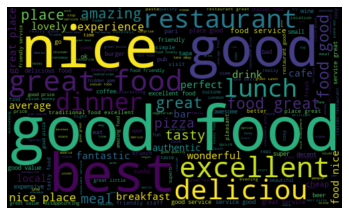

In [52]:
# Plot Word Cloud
all_words_1 = ' '.join( [reviews for reviews in df_sentiment['first_review'] if reviews != 'no comment'] )
all_words_2 = ' '.join( [reviews for reviews in df_sentiment['last_review'] if reviews != 'no comment'] )
all_words = all_words_1 +all_words_2
wordCloud = WordCloud(width = 500,height = 300, random_state = 21,max_font_size = 119).generate(all_words)

plt.imshow(wordCloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

As we may see, the most frequent words are 'Nice, good', 'food' etc. So people tend to remain more positive reviews and oftenly mention 'food'

Let's create a new column where we identify the sentiment itself

In [54]:
# Create a function to compute the negative, neutral and positive analysis

def get_analysis(score):
  if score <0:
    return 'negative'
  elif score == 0:
    return 'neutral'
  else:
    return 'positive'

In [57]:
df_sentiment['analysis_fst'] = df_sentiment['polarity_fst'].apply(get_analysis)
df_sentiment['analysis_snd'] = df_sentiment['polarity_snd'].apply(get_analysis)
df_sentiment.head()

,first_review,last_review,subjectivity_fst,subjectivity_snd,polarity_fst,polarity_snd,analysis_fst,analysis_snd
0,a good hotel restaurant,good food at your doorstep,0.6,0.6,0.700000,0.700,positive,positive
1,delicious nepalese food,unique cuisine,1.0,1.0,1.000000,0.375,positive,positive
2,not exceptional,catch up with friends,1.0,0.0,-0.333333,0.000,negative,neutral
3,no comment,no comment,0.0,0.0,0.000000,0.000,neutral,neutral
4,nice building but improvements need to be...,best place to try a bavarian food,1.0,0.3,0.600000,1.000,positive,positive


In [58]:
# # Print all of the positive reviews

# j=1
# sortedDF_1 = df_sentiment.sort_values(by='polarity_1')
# for i in range(0,sortedDF_1.shape[0]):
#   if (sortedDF_1['analysis_1'][i] == 'positive'):
#     print(str(j)+ ')' +sortedDF_1['review_1'][i])
#     print()
#     j += 1

Let's check how many positive feedback we have and how they changed

In [60]:
# Get the percentage of positive reviews
p_rev = df_sentiment[df_sentiment['analysis_fst']=='positive']
p_rev = p_rev['first_review']
round((p_rev.shape[0] / df_sentiment.shape[0])*100, 1)

49.4

In [61]:
# Get the percentage of positive reviews
p_rev = df_sentiment[df_sentiment['analysis_snd']=='positive']
p_rev = p_rev['last_review']
round((p_rev.shape[0] / df_sentiment.shape[0])*100, 1)

57.5

Well, we have increased positive feedbacks since the first review placed on the website and the last review. Interesting why?

Let's check how many negative feedback we have and how they changed

In [62]:
# Get the percentage of negative reviews
p_rev = df_sentiment[df_sentiment['analysis_fst']=='negative']
p_rev = p_rev['first_review']
round((p_rev.shape[0] / df_sentiment.shape[0])*100, 1)

6.3

In [63]:
# Get the percentage of negative reviews
p_rev = df_sentiment[df_sentiment['analysis_snd']=='negative']
p_rev = p_rev['last_review']
round((p_rev.shape[0] / df_sentiment.shape[0])*100, 1)

7.1

Same thing in negative feedback but not so significant

Let's see onto distribution of negative and positive feedbacks

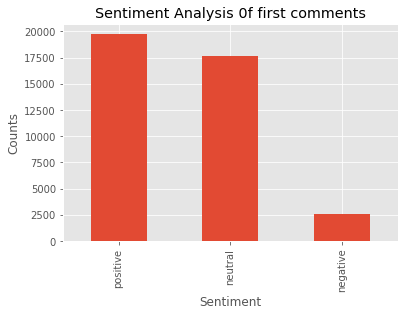

positive    19760
neutral     17703
negative     2537
Name: analysis_fst, dtype: int64

In [68]:
# plot and visualize

plt.title('Sentiment Analysis 0f first comments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_sentiment['analysis_fst'].value_counts().plot(kind='bar')
plt.show()

# show the value counts

df_sentiment['analysis_fst'].value_counts()

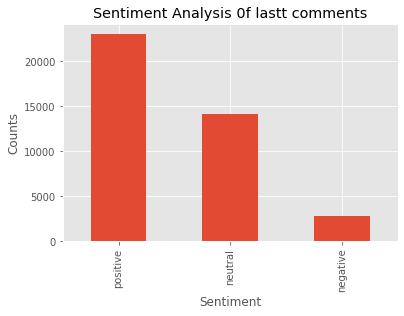

positive    23018
neutral     14143
negative     2839
Name: analysis_snd, dtype: int64

In [67]:
# plot and visualize

plt.title('Sentiment Analysis 0f lastt comments')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_sentiment['analysis_snd'].value_counts().plot(kind='bar')
plt.show()

# show the value counts

df_sentiment['analysis_snd'].value_counts()

As we may see, mnore or less it is same. We also note that we can't to refer into a neutral comments because we replaced the missing values with 'No comments' and it gives us neutral sentiment

In [ ]:
# Create a function to compute the negative, neutral and positive analysis

def get_analysis(score):
  if score <0:
    return 'negative'
  elif score == 0:
    return 'neutral'
  else:
    return 'positive'

In [25]:
lx = re.compile('\[\[.*\]\]')
hui = list()
for x in df['reviews']:
    if type(x) == str and lx.fullmatch(x):
        hui.append(x)


## 3. Feature Engineering and tidy dataset up

### 3.1 Restaurant_Id column

With a reference to EDA provided in Section 2, we may add one additional column which depict, whether the restaurant belongs to chain or not.

In [25]:
# Create a list with restaurants which might be in chain

chained_rest_list = list(df['restaurant_id'].value_counts()[
    df['restaurant_id'].value_counts() > 1].index)

# If it is in chain, we add in a new column the identificator '1', otherwise '0'
df['chained_rest'] = df[df['restaurant_id'].isin(
    chained_rest_list)].restaurant_id.apply(lambda x: 1)
df['chained_rest'] = df['chained_rest'].fillna(0)

# Check
df['chained_rest'].value_counts()

1.0    35295
0.0     4705
Name: chained_rest, dtype: int64

### 3.2 City column

Reduce the quantity of presented cities. Substitute rare cities by 'other'.

Fix name Oporto

In [26]:
# Fix Oporto
df['city'] = df['city'].replace(['Oporto'], 'Porto')

# !!! It works. Add or remove depend on MAE !!!

In [27]:
# Top cities

all_cities = df['city'].value_counts().index

# # Create a top Cites list (more than 20% in Dataset)
# top_cities_list = df['city'].value_counts()[
#     df['city'].value_counts() > np.percentile((df['city'].value_counts().values), 20)].index.tolist()

# cities_to_drop = list(set(all_cities)-set(top_cities_list))
# df.loc[df['city'].isin(cities_to_drop),'city'] = 'Other'




# # If City is TOP, we add in new column the identificator '1', otherwise '0'
# df['top_city'] = df[df['city'].isin(
#     top_cities_list)].city.apply(lambda x: 1)
# df['top_city'] = df['top_city'].fillna(0)

Let's add a column with information about whether the Restaraunt in a capital or not

In [28]:
# Cos we don't have too many cities, let's create a dict where mention whethere the city is a capital
capital = [True, True, True, False, True, False, True, 
           True, True, True, True, True, False, False, 
           False, True, True, True, True, True, True, 
           True, False, False, False, False, True, 
           True, True, True, True]

capital_dict = dict(zip(list(all_cities), capital))

In [29]:
df['capital'] = df['city'].map(capital_dict)

Encode the city Name

In [31]:
# Code here

Add population and add information to what country the city belongs

In [30]:
city_population = {
    'London': 8787892,
    'Paris': 2187526,
    'Madrid': 3300000,
    'Barcelona': 1593075,
    'Berlin': 3726902,
    'Milan': 1331586,
    'Rome': 2860000,
    'Prague': 1300000,
    'Lisbon': 505526,
    'Vienna': 1900000,
    'Amsterdam': 872080,
    'Brussels': 144784,
    'Hamburg': 1840000,
    'Munich': 1558395,
    'Lyon': 506615,
    'Stockholm': 975904,
    'Budapest': 1752286,
    'Warsaw': 1720398,
    'Dublin': 1793579 ,
    'Copenhagen': 1330993,
    'Athens': 3090508,
    'Edinburgh': 476100,
    'Zurich': 402275,
    'Porto': 237559,
    'Geneva': 196150,
    'Krakow': 779115,
    'Oslo': 697549,
    'Helsinki':  656229,
    'Bratislava': 563682,
    'Luxembourg': 626108,
    'Ljubljana': 295504
}

--- 

In [31]:
city_country = {
    'London': 'United Kingdom',
    'Paris': 'France',
    'Madrid': 'Spain',
    'Barcelona': 'Spain',
    'Berlin': 'Germany',
    'Milan': 'Italy',
    'Rome': 'Italy',
    'Prague': 'Czech',
    'Lisbon': 'Portugal',
    'Vienna': 'Austria',
    'Amsterdam': 'Netherlands',
    'Brussels': 'Belgium',
    'Hamburg': 'Germany',
    'Munich': 'Germany',
    'Lyon': 'France',
    'Stockholm': 'Sweden',
    'Budapest': 'Hungary',
    'Warsaw': 'Poland',
    'Dublin': 'Ireland' ,
    'Copenhagen': 'Denmark',
    'Athens': 'Greece',
    'Edinburgh': 'Schotland',
    'Zurich': 'Switzerland',
    'Porto': 'Portugal',
    'Geneva': 'Switzerland',
    'Krakow': 'Poland',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Bratislava': 'Slovakia',
    'Luxembourg': 'Luxembourg',
    'Ljubljana': 'Slovenija'
}

In [32]:
df['city_population'] = df['city'].map(city_population)
df['country'] = df['city'].map(city_country)

!!! Add Rank of city if can !!!

!!! Ad LEVEL OF LIFE !!!

### 3.3 Cuisine_style column

Let's add new feature - quantity of quisins in a restaurant

In [33]:
df['cuisine_count'] = df['cuisine_style'].apply(lambda x:len(x))

Add one more feature which tells that restaurant has in its set rare cuisine.

Assume rare value if it is met in dataset les than 50 times

In [34]:
cuisine_rare_lst = df.explode('cuisine_style')['cuisine_style'].value_counts()[
    df.explode('cuisine_style')['cuisine_style'].value_counts() < 50].index.tolist()

In [35]:
def get_cuisine_rare(row):
    
    '''Function called for creating a number of
    rare cuisins
    INPUT: A cell from dataset
    OUTPUT: Number of rare cuisins'''
    
    number = 0
    for i in cuisine_rare_lst:
        if i in row:
            number += 1
    return number

In [36]:
df['rare_cuisine'] = df['cuisine_style'].apply(get_cuisine_rare)

Is it important to know, whether the cuisine belongs to the region where it is comes from?

Lets add this feature

In [37]:
# Create a global variable (dict) with cuisines and related region of it
# I don't know how to use NLP for this case, so this work need to be done by hands :(

cuisine_region = {
    'France': ['French','Central European'],
    'Sweden':['Swedish','Scandinavian'],
    'United Kingdom':['British'],
    'Germany':['German','Central European'],
    'Italy':['Pizza','Italian'],
    'Slovakia':['Eastern European'],
    'Austria':['Austrian'],
    'Spain':['Spanish'],
    'Ireland':['Irish'],
    'Belgium':['Belgian'],
    'Switzerland':['Swiss'],
    'Poland':['Polish','Ukrainian'],
    'Hungary':['Hungarian'],
    'Denmark':['Scandinavian'],
    'Netherlands':['Dutch'],
    'Portugal':['Portuguese'],
    'Czech':['Czech'],
    'Norway':['Norwegian','Scandinavian'],
    'Finland':['Central European'],
    'Schotland':['Scottish'],
    'Slovenija':['Slovenian'],
    'Greece':['Greek'],
    'Luxembourg':['Central European']
}


In [38]:
def get_local_cuisine (row):
    
    '''Function called for identifying
    whether restaurant includes local
    cuisine or not
    INPUT: A cell from dataset
    OUTPUT: 1 - if includes
            0 - if does not include'''
    
    local_cuis = cuisine_region[row['country']]
    for i in local_cuis:
        if i in row['cuisine_style'] and i !='':
            return 1
    return 0

In [39]:
df['local_cuisine'] = df.apply(get_local_cuisine,axis = 1)

In [40]:
df['local_cuisine'].value_counts()

0    26555
1    13445
Name: local_cuisine, dtype: int64

With a reference to our EDA, we noticed that the Vegan and Gluten Free Options are very likely to be reviewed by the customers. Let's add the feature, whether restaurant includes a vegan food.

In [41]:
def get_vegan(row):
    vegan_cuis = ['Vegetarian Friendly', 'Vegan Options',
                  'Gluten Free Options', 'Healthy', ]
    for i in vegan_cuis:
        if i in row['cuisine_style'] and i != '':
            return 1
    return 0

In [44]:
df['vegan_include'] = df.apply(get_vegan,axis = 1)

### 3.4 Ranking column

With a reference to EDA section 2.5 let's create a column with equivalent ranking

Step 1: Create a total number of a restaurants in a single city

In [42]:
city_restaurant = dict(df['city'].value_counts())
df['restaurant_qty'] = df['city'].map(city_restaurant)

Step 2: Create an equivalent ranking

In [43]:
df['equiv_ranking'] = df['ranking']/df['restaurant_qty']

Step 3. Check distribution of a normalized ranking

Text(0, 0.5, 'Quantity (frequency)')

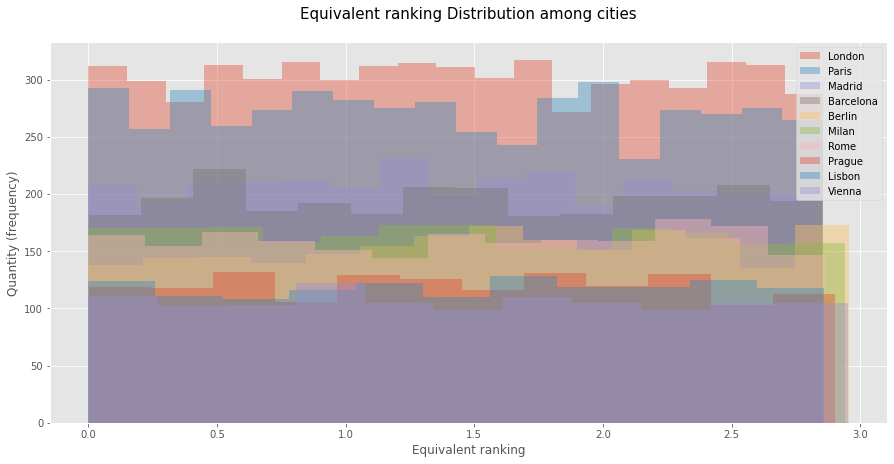

In [44]:
plt.figure(figsize=(15 ,7))

for city in (df['city'].value_counts())[0:10].index:  
    sns.distplot(df['equiv_ranking'][df['city'] == city],kde=False,label = city)
    
plt.legend(prop={'size': 10})
plt.title('Equivalent ranking Distribution among cities\n', fontsize=15)
plt.xlabel('Equivalent ranking')
plt.ylabel('Quantity (frequency)')

Well, now it is looks better than in section 2.5. Distribution is normal

Create a column with mean value of people to a single restaurant in a city

In [45]:
df['people_per_restaur'] = df['city_population']/df['restaurant_qty']

### 3.5 Price range column

!!! ENcODE IT !!!

In [63]:
#df['id_ta'] = df['id_ta'].apply(lambda x: int(x[1:]))